<a href="https://colab.research.google.com/github/riskydav/Orbit-Future-Academy/blob/main/35_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Selasa, 2 November 2021 (Data dalam Computer Vision)

**REFERENSI**

[Image Preprocessing in Python](https://www.section.io/engineering-education/image-preprocessing-in-python/)

In [1]:
#Install library yang dibutuhkan
#link gambar https://github.com/riskydav/Orbit-Future-Academy/blob/main/Dataset/cat.jpg

!pip install d2l==0.17.0 
!pip install -U mxnet-cu101==1.7.0

     |████████████████████████████████| 83 kB 1.4 MB/s 
     |███████████████████████████████▌| 834.1 MB 1.4 MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x55656add6000 @  0x7fc472c8a615 0x5565324f44cc 0x5565325d447a 0x5565324f72ed 0x5565325e8e1d 0x55653256ae99 0x5565325659ee 0x5565324f8bda 0x55653256ad00 0x5565325659ee 0x5565324f8bda 0x556532567737 0x5565325e9c66 0x556532566daf 0x5565325e9c66 0x556532566daf 0x5565325e9c66 0x556532566daf 0x5565324f9039 0x55653253c409 0x5565324f7c52 0x55653256ac25 0x5565325659ee 0x5565324f8bda 0x556532567737 0x5565325659ee 0x5565324f8bda 0x556532566915 0x5565324f8afa 0x556532566c0d 0x5565325659ee
     |████████████████████████████████| 846.0 MB 21 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Image Augmentation
:label:`sec_image_augmentation`

In :numref:`sec_alexnet`, 
Dalam :numref:sec_alexnet, disebutkan bahwa dataset yang besar merupakan prasyarat utama untuk mencapai keberhasilan neural network dalam di berbagai aplikasi. Augmentasi gambar menghasilkan contoh data training yang serupa tetapi berbeda setelah serangkaian perubahan random pada gambar training, sehingga memperluas ukuran serta variasi dataset. Sebagai contoh, augmentasi gambar didukung oleh fakta bahwa perubahan random dari contoh dataset training yang memungkinkan model untuk tidak terlalu bergantung pada atribut tertentu, sehingga meningkatkan kemampuan generalisasinya. Misalnya, kita dapat memotong gambar/crop dengan cara yang berbeda untuk membuat objek yang diinginkan muncul di posisi yang berbeda, sehingga mengurangi ketergantungan model pada posisi objek. Kita juga dapat menyesuaikan faktor seperti kecerahan dan warna untuk mengurangi sensitivitas model terhadap warna. 


In [2]:
# Detail lebih lanjut https://mxnet.apache.org/versions/1.6/api/python/docs/api/autograd/index.html
# Autograd for NDArray berguna untuk menghitung turunan (banyak digunakan untuk neural net specially backprop) serta membedakan kode python pure dengan numpy 
# Gluon menyediakan api deep learning baik itu jst dan lainnya, mirip seperti model milik keras & tensorflow.'
# Image adalah api yang berisi fungsi" iterator (penelusuran batch gambar) dan juga augmentasi serta cocok banget digunakan bersama dengan iterator data mxnet.io. Untuk augmentasi dan transformasi dalam gluon dengan Datasets dan DataLoaders
# init untuk inisialisasi weight di NN
# np api yang menyediakan pemrosesan dan pengolahan data numpy
# npx adalah NumPy Neural Network Extension berisi beberapa extensi yang berguna dalam pemrosesan numpy data di neural network

%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np() # Mengatur bentuk NumPy dan array semantik secara bersamaan

## Metode Image Augementation yang Umum digunakan

Beberapa sumber menjelaskan mengenai metode umum yang digunakan pada proses augmentasi gambar. Secara umum kita akan menggunakan gambar dengan ukuran $400\times 500$ sebagai contoh


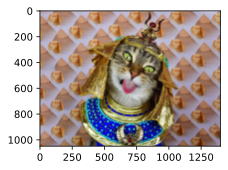

In [3]:
d2l.set_figsize()
#upload image ke local colab 
img = image.imread('/content/cat.jpg')
d2l.plt.imshow(img.asnumpy());

Sebagian besar metode augmentasi gambar memiliki tingkat random tertentu. Untuk memudahkan kita mengamati efek augmentasi gambar, selanjutnya kita mendefinisikan fungsi bantu bernama `apply`. Fungsi ini menjalankan metode augmentasi gambar `aug` beberapa kali pada gambar input `img` dan menampilkan 
semua hasilnya.

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### Flipping dan Cropping


[**Flipping gambar ke kiri atau kanan**] biasanya tidak mengubah kategori objek.
Ini adalah salah satu metode augmentasi gambar yang paling awal dan paling banyak digunakan.
Selanjutnya, kita menggunakan perintah `transforms` untuk membuat instance `RandomFlipLeftRight`, yang mem-flip
gambar ke kiri atau kanan dengan probabilitas sebesar 50%.


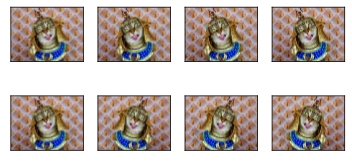

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

[**Flipping up and down**] tidak biasa dipakai seperti flip ke kiri dan ke kanan. Tapi setidaknya untuk contoh gambar ini, membalik ke atas dan ke bawah tidak menghalangi model dalam melakukan pengenalan. Selanjutnya, kita akan mencoba membuat instance RandomFlipTopBottom untuk membalik gambar ke atas dan ke bawah dengan probabilitas 50%.


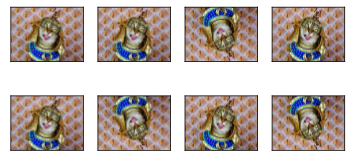

In [6]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

Pada contoh gambar ini, kucing berada di tengah gambar, tetapi posisi ini tidak terjadi pada semua kondisi.
Dalam :numref:`sec_pooling`, dijelaskan bahwa pooling layer dapat mengurangi sensitivitas convolutional layer ke posisi target.
Selain itu, kita juga dapat memotong gambar secara acak untuk membuat objek muncul pada posisi berbeda didalam gambar pada skala berbeda, yang juga dapat mengurangi sensitivitas model terhadap posisi target.

Pada potongan kode dibawah ini [**crop random**] sebuah area dengan luas $10\% \sim 100\%$ dari luas aslinya diambil, dan rasio lebar terhadap tinggi area ini dipilih secara acak dari $0,5 \sim 2$. Kemudian, lebar dan tinggi area keduanya diskalakan menjadi 200 piksel.
Kecuali ditentukan pada kondisi tertentu, angka acak antara $a$ dan $b$ di bagian ini mengacu pada nilai kontinu yang diperoleh dengan pengambilan sampel acak dan seragam dari interval $[a, b]$.


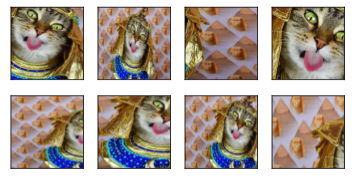

In [7]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Merubah colour

Metode augmentasi lainnya adalah mengubah warna. Kita dapat mengubah empat aspek warna gambar: brightness, contrast, saturation, dan hue. Pada contoh di bawah, kita [**mengubah kecerahan secara acak**] gambar ke nilai antara 50% ($1-0.5$) dan 150% ($1+0.5$) dari gambar aslinya.


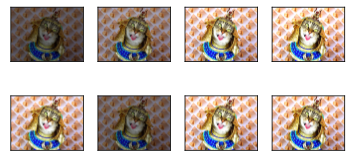

In [8]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

Dengan cara yang sama, kita bisa **mengubah tingkat hue nya**


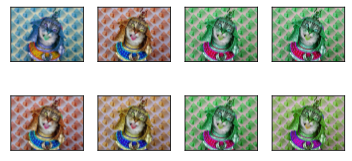

In [9]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

Disini kita bisa menggunakan dan membuat instance `RandomColorJitter` dan berguna untuk [**mengubah `brightness`, `contrast`, `saturation`, dan `hue` pada gambar secara acak dan dalam waktu yang sama**].


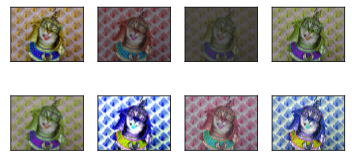

In [10]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### Menggabungkan beberapa metode image augmentation

Sebagai latihan, kita akan mencoba [**menggabungkan bebrapa metode image augmentation**]. 
Sebagai contoh,
kita bisa menggabungkan metode augmentasi yang berbeda yang telah dipelajari sebelumnhya, dan menerapkannya pada setiao image menggunakan instance 'Compose'


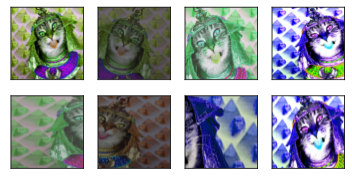

In [11]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## [**Training dengan Image Augmentation**]

Mari kita coba latih model dengan image augmentation.
Di sini kita akan menggunakan dataset CIFAR-10 sebagai pengganti dataset Fashion-MNIST yang pernah kita gunakan.
Hal ini dikarenakan position dan size objek pada dataset Fashion-MNIST telah di-normalize, sedangkan color dan size objek pada dataset CIFAR-10 memiliki perbedaan yang lebih signifikan.
32 gambar pelatihan pertama dalam kumpulan data CIFAR-10 ditunjukkan di bawah ini.



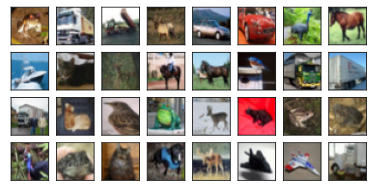

In [12]:
d2l.show_images(
    gluon.data.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);

Untuk mendapatkan hasil yang pasti selama prediksi, kita dapat menerapkan augmentasi gambar pada contoh pelatihan, dan tidak menggunakan augmentasi gambar dengan random-operation selama prediksi.
[**Di sini yang dicontohkan hanya menggunakan metode fliping ke kiri-kanan secara acak dengan metode yang paling sederhana**]. Selain itu, kita menggunakan instance `ToTensor` untuk mengonversi minibatch gambar ke dalam format yang diperlukan oleh framework deep learning, yaitu,
Angka floating point 32-bit antara 0 dan 1 dengan format (ukuran batch, jumlah channel, tinggi, lebar).

In [13]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

Next, kita definisikan fungsi tambahan untuk membantu proses pembacaan gambar dan implementasi image augmentation
Fungsi `transform_first` disediakan oleh Gluon
image augmentation diterapkan pada setiap elemen pertama pada saat training?
contoh (image dan label), detainya adalah gambar
Untuk info lebih dalam, silahkan masuk ke `DataLoader`, serta merujuk ke :numref:`sec_fashion_mnist`.


In [14]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

### Multi-GPU Training

kita akan coba melatih model ResNet-18 dari
:numref:`sec_resnet` pada dataset CIFAR-10.
pelatihan multi-GPU di :numref:`sec_multi_gpu_concise`.
Berikut ini,
[**kita definisikan fungsi untuk melatih dan mengevaluasi model menggunakan multi GPU**].


In [15]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, devices,
                     split_f=d2l.split_batch):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    X_shards, y_shards = split_f(features, labels, devices)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [
            loss(pred_shard, y_shard)
            for pred_shard, y_shard in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The `True` flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(
        d2l.accuracy(pred_shard, y_shard)
        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [16]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus(), split_f=d2l.split_batch):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

Sekarang kita dapat [**mendefinisikan fungsi `train_with_data_aug` untuk melatih model dengan image augemtation**].
Fungsi ini menggunakan semua GPU yang tersedia,
menggunakan Adam sebagai algoritma optimasi,
menerapkan augmentasi gambar ke dataset training,
dan akhirnya memanggil fungsi `train_ch13` yang baru saja ditentukan untuk melatih dan mengevaluasi model.

In [17]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Mari kita [**melatih model**] menggunakan image augmentation dengan flipping ke kiri-kanan secara random

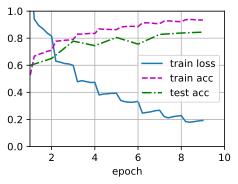

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

## Ringkasan

* Augmentasi gambar menghasilkan gambar acak berdasarkan data pelatihan yang ada untuk meningkatkan kemampuan generalisasi model.
* Untuk mendapatkan hasil yang pasti selama prediksi, kita biasanya hanya menerapkan augmentasi gambar pada data training, dan tidak menggunakan augmentasi gambar dengan random operation saat memprediksi.
* deep learning framework menyediakan banyak metode augmentasi gambar yang berbeda, yang dapat diterapkan secara bersamaan.


## Latihan

1. Latih model tanpa menggunakan augmentasi gambar: `train_with_data_aug(test_augs, test_augs)`. Bandingkan pelatihan dan pengujian akurasi saat menggunakan dan tidak menggunakan augmentasi gambar. Dapatkah eksperimen komparatif ini mendukung argumen bahwa augmentasi gambar dapat mengurangi overfitting? Mengapa?
1. Menggabungkan beberapa metode augmentasi gambar yang berbeda dalam pelatihan model pada set data CIFAR-10. Apakah itu meningkatkan akurasi tes?
1. Lihat dokumentasi online deep learning framework. Apa metode image augmentation lain yang juga disediakannya?

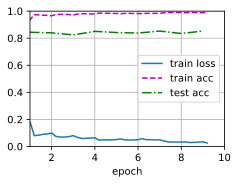

In [ ]:
train_with_data_aug(test_augs, test_augs, net)